I have got inspired from the following article and have following his set of code and instruction for my understand on color identification and the application out of it

https://towardsdatascience.com/color-identification-in-images-machine-learning-application-b26e770c4c71

In [1]:
!pip install opencv-python

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os

%matplotlib inline

In [3]:
### Working with Open CV

The type of this input is <class 'numpy.ndarray'>
Shape: (960, 1280, 3)


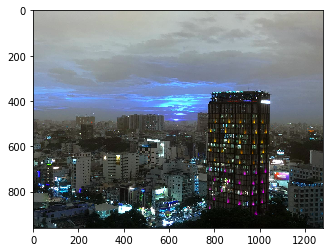

In [4]:
image = cv2.imread('sample_images.jpg')
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

The shape of the array is (960,1280, 3). The first two values match the pixels of the image. Third value is set to 3 as each pixel is represented as a combination of three colors, Red, Blue and Green.

We see that the image has different colors as compared to the original image. This is because by default OpenCV reads the images in the color order BLUE GREEN RED i.e. BGR. Thus, we need to convert it into REG GREEN BLUE i.e. RGB.

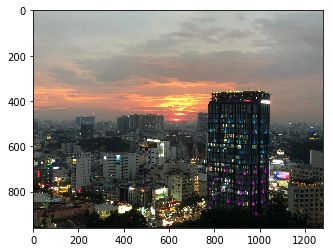

In [5]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

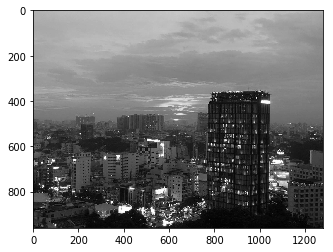

In [6]:
# the same we can convert image into gray color
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

We can also resize the image to a given dimension. We use the method resize provided by cv2. The first argument is the image we want to resize, and the second argument is the width and height defined within parentheses.

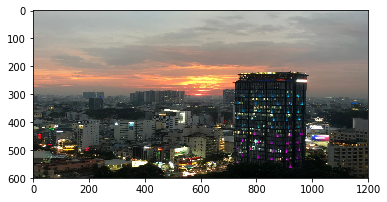

In [7]:
resized_image = cv2.resize(image, (1200, 600))
plt.imshow(resized_image)

### Color Identification

In [8]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

On reading the color which is in RGB space, we return a string. {:02x} simply displays the hex value for the respective color.

In [9]:
# NOW, we define a method that will help us get an image into Python in the RGB space.

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [10]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

From the above set of code, we can explain the logic as the following

First, we resize the image to the size 600 x 400. It is not required to resize it to a smaller size but we do so to lessen the pixels which’ll reduce the time needed to extract the colors from the image. KMeans expects the input to be of two dimensions, so we use Numpy’s reshape function to reshape the image data.

KMeans algorithm creates clusters based on the supplied count of clusters. In our case, it will form clusters of colors and these clusters will be our top colors. We then fit and predict on the same image to extract the prediction into the variable labels.

[array([244.27783505, 241.46185567, 226.15927835]),
 array([59.2556403 , 61.82848353, 58.08931547]),
 array([201.81237991, 138.62462256, 114.3724952 ]),
 array([161.90830633, 156.56731364, 148.56749572]),
 array([88.33078281, 90.42431823, 84.04890131]),
 array([144.1927423 , 130.06883192, 121.37121457]),
 array([12.83574184, 17.00425031, 15.70411299]),
 array([244.70808449, 176.00975965, 110.63131828]),
 array([180.35969249, 182.18963063, 175.29793182]),
 array([34.10150627, 38.02303556, 36.79867298])]

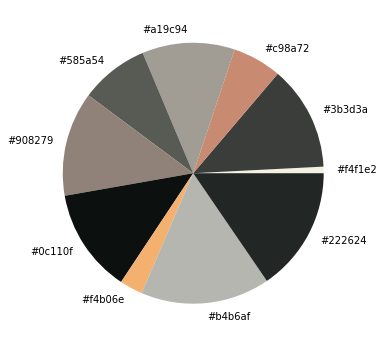

In [13]:
get_colors(get_image('sample_images.jpg'), 10, True)

We use Counter to get count of all labels. To find the colors, we use clf.cluster_centers_. The ordered_colors iterates over the keys present in count, and then divides each value by 255. We could have directly divided each value by 255 but that would have disrupted the order.
Next, we get the hex and rgb colors. As we divided each color by 255 before, we now multiply it by 255 again while finding the colors. If show_chart is True, we plot a pie chart with each pie chart portion defined using count.values(), labels as hex_colors and colors as ordered_colors. We finally return the rgb_colors which we’ll use at a later stage.

### Application: Search images using color

From the model above, we can extract the major colors. This create the opportunity to search for images based on certain colors. We can select a color and if it's hex matches or is close to the hex of the major colors of the image, we say it's a match.

We first get all the images and store them in the images variable.

In [15]:
IMAGE_DIRECTORY = 'images'
COLORS = {
    'GREEN': [0, 128, 0],
    'BLUE': [0, 0, 128],
    'YELLOW': [255, 255, 0]
}
images = []

for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

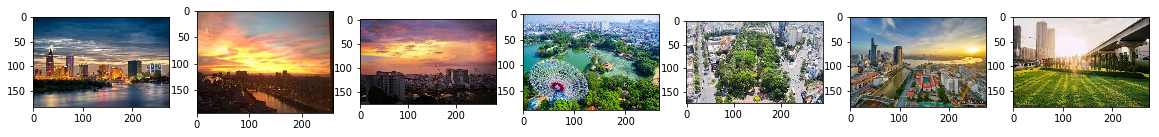

In [16]:

plt.figure(figsize=(20, 10))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

In [17]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        if (diff < threshold):
            select_image = True
    
    return select_image

In [18]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            index += 1

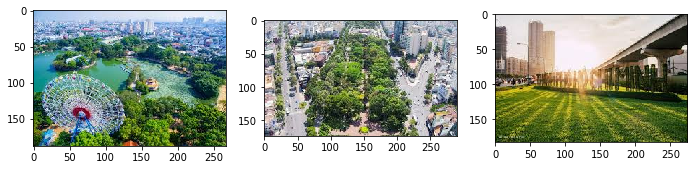

In [19]:

# Search for GREEN
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['GREEN'], 60, 5)

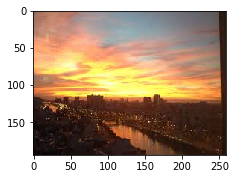

In [21]:

# Search for Yellow
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['YELLOW'], 60, 5)